In [2]:
import pandas as pd
import numpy as np
from google.colab import drive

In [3]:
!pip install pennylane pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 84.

In [4]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch import nn


n_qubits = 4  # Nombre de qubits
n_features = 4  # hr_bpm, rr_ms, speed_yds_per_s, acc_yds_per_s2

# Device quantique (simulateur)
dev = qml.device('default.qubit', wires=n_qubits)


@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):

    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)


    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])


    for i in range(n_qubits):
        qml.RY(weights[i, 0], wires=i)
        qml.RZ(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)


    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])


    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    """
    Couche quantique compatible PyTorch
    """
    def __init__(self, n_qubits):
        super().__init__()
        self.n_qubits = n_qubits

        self.weights = nn.Parameter(
            torch.randn(n_qubits, 3, dtype=torch.float32) * 0.1
        )

    def forward(self, x):
        batch_size = x.shape[0]
        outputs = []

        for i in range(batch_size):
            result = quantum_circuit(x[i], self.weights)
            result_tensor = torch.stack([r.float() for r in result])
            outputs.append(result_tensor)

        return torch.stack(outputs)


class HybridQuantumModel(nn.Module):
    def __init__(self, n_features, n_qubits, n_classes):
        super().__init__()

        self.pre_net = nn.Sequential(
            nn.Linear(n_features, 8),
            nn.ReLU(),
            nn.Linear(8, n_qubits)
        )

        self.quantum_layer = QuantumLayer(n_qubits)

        self.post_net = nn.Sequential(
            nn.Linear(n_qubits, 8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(8, n_classes)
        )

    def forward(self, x):
        x = x.float()

        x = self.pre_net(x)

        x = torch.tanh(x) * np.pi

        # Circuit quantique
        x = self.quantum_layer(x)

        # Post-traitement et classification
        x = self.post_net(x)

        return x


if __name__ == "__main__":
    # Créer le modèle
    model = HybridQuantumModel(
        n_features=4,
        n_qubits=4,
        n_classes=5
    )

    batch_size = 8
    x_test = torch.randn(batch_size, 4, dtype=torch.float32)

    print("Test du modèle hybride quantique:")
    print(f"Input shape: {x_test.shape}")
    print(f"Input dtype: {x_test.dtype}")

    output = model(x_test)
    print(f"\nOutput shape: {output.shape}")
    print(f"Output dtype: {output.dtype}")
    print(f"Output:\n{output}")

    loss = output.sum()
    loss.backward()
    print(f"\n✓ Gradients calculés avec succès")
    print(f"✓ Quantum layer weights gradient shape: {model.quantum_layer.weights.grad.shape}")
    print(f"✓ Quantum layer weights gradient dtype: {model.quantum_layer.weights.grad.dtype}")

Test du modèle hybride quantique:
Input shape: torch.Size([8, 4])
Input dtype: torch.float32

Output shape: torch.Size([8, 5])
Output dtype: torch.float32
Output:
tensor([[-0.1170,  0.1096, -0.3054,  0.2176,  0.2788],
        [-0.1109,  0.1104, -0.3020,  0.2243,  0.2753],
        [-0.1326,  0.1071, -0.3119,  0.2050,  0.2859],
        [-0.2220,  0.0927, -0.2466,  0.2920,  0.2628],
        [-0.0913,  0.1127, -0.2893,  0.2493,  0.2631],
        [ 0.0580,  0.1577, -0.3630,  0.1009,  0.2935],
        [-0.1432,  0.1044, -0.3096,  0.2097,  0.2858],
        [-0.0132,  0.1444, -0.2275,  0.3048,  0.2220]],
       grad_fn=<AddmmBackward0>)

✓ Gradients calculés avec succès
✓ Quantum layer weights gradient shape: torch.Size([4, 3])
✓ Quantum layer weights gradient dtype: torch.float32


In [5]:
drive.mount('/content/drive')

import os

# Dossier du projet dans Drive
BASE_DIR = '/content/drive/Shareddrives/POC - Compute Quantum/Projet GamePule Data'

# Noms exacts des CSV (adapter si vous les renommez)
POLAR_FILE = 'polar_h10_signals_1hz_2min (1).csv'
ZEBRA_FILE = 'zebra_rfid_signals_2hz_2min (2).csv'

# Chemins complets
POLAR_PATH = os.path.join(BASE_DIR, POLAR_FILE)
ZEBRA_PATH = os.path.join(BASE_DIR, ZEBRA_FILE)

print('✅ Google Drive monté')
print('📂 Dossier  :', BASE_DIR)
print('📄 Polar    :', POLAR_PATH)
print('📄 Zebra    :', ZEBRA_PATH)

# Vérification simple
for p in (POLAR_PATH, ZEBRA_PATH):
    if not os.path.exists(p):
        print('⚠️ Fichier introuvable :', p, '\n   → Vérifiez le nom exact dans Drive.')


Mounted at /content/drive
✅ Google Drive monté
📂 Dossier  : /content/drive/Shareddrives/POC - Compute Quantum/Projet GamePule Data
📄 Polar    : /content/drive/Shareddrives/POC - Compute Quantum/Projet GamePule Data/polar_h10_signals_1hz_2min (1).csv
📄 Zebra    : /content/drive/Shareddrives/POC - Compute Quantum/Projet GamePule Data/zebra_rfid_signals_2hz_2min (2).csv


In [6]:
polar_df = pd.read_csv(POLAR_PATH)
zebra_df = pd.read_csv(ZEBRA_PATH)

In [7]:
polar_df

,timestamp,player_id,group,hr_bpm,rr_ms
0,2025-08-10T05:58:45,P1,Actifs,123.708977,490.825082
1,2025-08-10T05:58:46,P1,Actifs,122.449601,490.048678
2,2025-08-10T05:58:47,P1,Actifs,120.150213,494.467352
3,2025-08-10T05:58:48,P1,Actifs,120.054400,502.083954
4,2025-08-10T05:58:49,P1,Actifs,120.444658,499.149395
...,...,...,...,...,...
4795,2025-08-10T06:00:40,P40,Rotation,76.291325,782.417696
4796,2025-08-10T06:00:41,P40,Rotation,75.372291,792.235606
4797,2025-08-10T06:00:42,P40,Rotation,74.746378,807.933367
4798,2025-08-10T06:00:43,P40,Rotation,74.545520,796.616829


| Colonne     | Type       | Description                                                                          |
| ----------- | ---------- | ------------------------------------------------------------------------------------ |
| `timestamp` | datetime64 | Horodatage de la mesure, converti en format datetime.                                |
| `player_id` | object     | Identifiant du joueur (ex. `'P1'`). Si absent dans le CSV, rempli par défaut `'P1'`. |
| `hr_bpm`    | float      | Fréquence cardiaque (battements par minute).                                         |
| `rr_ms`     | float      | Intervalle RR en millisecondes (mesure de variabilité cardiaque).                    |
| `group`     | object     | Groupe ou état du joueur, si présent (ex. `'Actifs'`).                               |


In [8]:
zebra_df

,timestamp,player_id,group,speed_yds_per_s,acc_yds_per_s2
0,2025-08-10T05:58:45,P1,Actifs,0.378478,0.078103
1,2025-08-10T05:58:45.500000,P1,Actifs,0.456582,-0.014183
2,2025-08-10T05:58:46,P1,Actifs,0.357204,-0.011881
3,2025-08-10T05:58:46.500000,P1,Actifs,0.360656,0.070767
4,2025-08-10T05:58:47,P1,Actifs,0.562733,0.047686
...,...,...,...,...,...
9595,2025-08-10T06:00:42.500000,P40,Rotation,1.441749,-0.000477
9596,2025-08-10T06:00:43,P40,Rotation,1.421961,-0.012025
9597,2025-08-10T06:00:43.500000,P40,Rotation,1.403055,0.004845
9598,2025-08-10T06:00:44,P40,Rotation,1.449017,0.015616


| Colonne           | Type       | Description                                                              |
| ----------------- | ---------- | ------------------------------------------------------------------------ |
| `timestamp`       | datetime64 | Horodatage de la mesure, converti en datetime.                           |
| `player_id`       | object     | Identifiant du joueur (ex. `'P1'`). Si absent, rempli par défaut `'P1'`. |
| `speed_yds_per_s` | float      | Vitesse du joueur en yards par seconde.                                  |
| `acc_yds_per_s2`  | float      | Accélération du joueur en yards par seconde².                            |
| `group`           | object     | Groupe ou état du joueur, si présent.                                    |


In [9]:
polar_df.isna().sum()

,0
timestamp,0
player_id,0
group,0
hr_bpm,0
rr_ms,0


In [10]:
zebra_df.isna().sum()

,0
timestamp,0
player_id,0
group,0
speed_yds_per_s,0
acc_yds_per_s2,0


In [11]:
polar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4800 non-null   object 
 1   player_id  4800 non-null   object 
 2   group      4800 non-null   object 
 3   hr_bpm     4800 non-null   float64
 4   rr_ms      4800 non-null   float64
dtypes: float64(2), object(3)
memory usage: 187.6+ KB


In [12]:
zebra_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        9600 non-null   object 
 1   player_id        9600 non-null   object 
 2   group            9600 non-null   object 
 3   speed_yds_per_s  9600 non-null   float64
 4   acc_yds_per_s2   9600 non-null   float64
dtypes: float64(2), object(3)
memory usage: 375.1+ KB


In [13]:
polar_df = polar_df.rename(columns={
    'time': 'timestamp',
    'hr': 'hr_bpm',
    'rr': 'rr_ms'
})
zebra_df = zebra_df.rename(columns={
    'time': 'timestamp',
    'speed': 'speed_yds_per_s',
    'acc': 'acc_yds_per_s2'
})

In [14]:
def parse_iso8601(series):
    return pd.to_datetime(series.astype(str), format='ISO8601', errors='coerce')

In [15]:
polar_df['timestamp'] = parse_iso8601(polar_df['timestamp'])
zebra_df['timestamp'] = parse_iso8601(zebra_df['timestamp'])

In [16]:
polar_df = polar_df.sort_values(['player_id', 'timestamp'])
zebra_df = zebra_df.sort_values(['player_id', 'timestamp'])

In [17]:
merged_list = []
for pid, pgrp in polar_df.groupby('player_id'):
    zgrp = zebra_df[zebra_df['player_id'] == pid]
    if zgrp.empty:
        tmp = pgrp.copy()
    else:
        tmp = pd.merge_asof(
            pgrp.sort_values('timestamp'),
            zgrp.sort_values('timestamp'),
            on='timestamp',
            direction='nearest',
            tolerance=pd.Timedelta('500ms'),
            suffixes=('', '_z')
        )
    merged_list.append(tmp)

df = pd.concat(merged_list, ignore_index=True)

In [18]:
display(df)

,timestamp,player_id,group,hr_bpm,rr_ms,player_id_z,group_z,speed_yds_per_s,acc_yds_per_s2
0,2025-08-10 05:58:45,P1,Actifs,123.708977,490.825082,P1,Actifs,0.378478,0.078103
1,2025-08-10 05:58:46,P1,Actifs,122.449601,490.048678,P1,Actifs,0.357204,-0.011881
2,2025-08-10 05:58:47,P1,Actifs,120.150213,494.467352,P1,Actifs,0.562733,0.047686
3,2025-08-10 05:58:48,P1,Actifs,120.054400,502.083954,P1,Actifs,0.328747,-0.123411
4,2025-08-10 05:58:49,P1,Actifs,120.444658,499.149395,P1,Actifs,0.333594,-0.013559
...,...,...,...,...,...,...,...,...,...
4795,2025-08-10 06:00:40,P9,Actifs,139.254855,428.974652,P9,Actifs,10.605863,-0.072157
4796,2025-08-10 06:00:41,P9,Actifs,139.926973,429.952325,P9,Actifs,10.563441,0.024213
4797,2025-08-10 06:00:42,P9,Actifs,138.895458,435.212015,P9,Actifs,10.660118,0.007814
4798,2025-08-10 06:00:43,P9,Actifs,137.791821,434.361149,P9,Actifs,10.707688,-0.006065


In [19]:
df.isna().sum()

,0
timestamp,0
player_id,0
group,0
hr_bpm,0
rr_ms,0
player_id_z,0
group_z,0
speed_yds_per_s,0
acc_yds_per_s2,0


In [20]:
def to_fatigue_snapshot(df_metrics: pd.DataFrame) -> pd.DataFrame:
    d = (df_metrics
         .sort_values(["player_id", "timestamp"])
         .groupby("player_id", as_index=False, sort=False)
         .tail(1)
         .copy())

    for col in ["hr_bpm", "speed_yds_per_s", "acc_yds_per_s2"]:
        if col not in d.columns:
            d[col] = np.nan
        d[col] = pd.to_numeric(d[col], errors="coerce").fillna(0.0)

    for col in ["hr_bpm", "speed_yds_per_s", "acc_yds_per_s2"]:
        d[col + "_n"] = d[col].rank(pct=True)

    score = (
        0.50 * d["hr_bpm_n"] +
        0.30 * d["speed_yds_per_s_n"] +
        0.20 * d["acc_yds_per_s2_n"]
    )

    try:
        levels = pd.qcut(score, 5, labels=[1,2,3,4,5]).astype(int)
    except Exception:
        levels = pd.cut(score, bins=np.linspace(0, 1, 6),
                        labels=[1,2,3,4,5], include_lowest=True).astype(int)

    out = pd.DataFrame({
        "PlayerID": d["player_id"].astype(str).str.upper(),
        "FatigueLevel": levels
    })
    return out

In [21]:
pred0 = to_fatigue_snapshot(df)

In [22]:
pred0

,PlayerID,FatigueLevel
119,P1,5
239,P10,4
359,P11,4
479,P12,4
599,P13,4
719,P14,3
839,P15,3
959,P16,4
1079,P17,2
1199,P18,2


In [23]:
def decision_from_level(level: int) -> str:
    l = int(level)
    if l <= 2: return "Stay / Play"
    if l == 3: return "Rest"
    return "Substitute"

In [24]:
pred0["Decision"] = pred0["FatigueLevel"].apply(decision_from_level)

In [25]:
display(df.head(3))
display(pred0.head())

,timestamp,player_id,group,hr_bpm,rr_ms,player_id_z,group_z,speed_yds_per_s,acc_yds_per_s2
0,2025-08-10 05:58:45,P1,Actifs,123.708977,490.825082,P1,Actifs,0.378478,0.078103
1,2025-08-10 05:58:46,P1,Actifs,122.449601,490.048678,P1,Actifs,0.357204,-0.011881
2,2025-08-10 05:58:47,P1,Actifs,120.150213,494.467352,P1,Actifs,0.562733,0.047686


,PlayerID,FatigueLevel,Decision
119,P1,5,Substitute
239,P10,4,Substitute
359,P11,4,Substitute
479,P12,4,Substitute
599,P13,4,Substitute


In [26]:
WIN, STRIDE = 32, 4
FEATURES = ['hr_bpm','rr_ms','speed_yds_per_s','acc_yds_per_s2']
assert set(FEATURES) <= set(df.columns), f"Colonnes manquantes: {set(FEATURES) - set(df.columns)}"
assert {'player_id', 'timestamp'} <= set(df.columns), "df doit contenir 'player_id' et 'timestamp'"

def add_targets_per_player(dfg: pd.DataFrame) -> pd.DataFrame:
    x = dfg.sort_values('timestamp').copy()

    # Z-score simple
    for col in FEATURES:
        x[col + '_z'] = (x[col] - x[col].mean()) / x[col].std()

    # Score stress pondéré et lissé (~5 échantillons)
    stress = (
        0.45 * x['hr_bpm_z'] +
        0.35 * x['speed_yds_per_s_z'] +
        0.20 * x['acc_yds_per_s2_z'] -
        0.10 * x['rr_ms_z']
    ).rolling(5, center=True, min_periods=1).mean()

    # Mise à l’échelle 0..1
    s = (stress - stress.min()) / (stress.max() - stress.min())

    # Discrétisation 1..5
    x['fatigue_level'] = pd.cut(
        s, bins=[-0.01, 0.2, 0.4, 0.6, 0.8, 1.01],
        labels=[1, 2, 3, 4, 5], include_lowest=True
    ).astype(int)

    return x


rolling mean sert à lisser les variations rapides du stress.

On ne réagit pas à un pic isolé, mais à une tendance sur 5 mesures.

| Aspect          | Bloc 3                           | Bloc 4                                                   |
| --------------- | -------------------------------- | -------------------------------------------------------- |
| Type de fatigue | Instantanée / snapshot           | Dynamique / continue                                     |
| Base            | Dernière mesure de chaque joueur | Toutes les mesures avec rolling mean                     |
| Normalisation   | Percentile (rank)                | Z-score                                                  |
| Sortie          | 1 niveau par joueur              | 1 niveau par joueur **et par timestamp**                 |
| Utilité         | Décision rapide / rapport        | Analyse détaillée et prédiction de fatigue en temps réel |


In [27]:
df

,timestamp,player_id,group,hr_bpm,rr_ms,player_id_z,group_z,speed_yds_per_s,acc_yds_per_s2
0,2025-08-10 05:58:45,P1,Actifs,123.708977,490.825082,P1,Actifs,0.378478,0.078103
1,2025-08-10 05:58:46,P1,Actifs,122.449601,490.048678,P1,Actifs,0.357204,-0.011881
2,2025-08-10 05:58:47,P1,Actifs,120.150213,494.467352,P1,Actifs,0.562733,0.047686
3,2025-08-10 05:58:48,P1,Actifs,120.054400,502.083954,P1,Actifs,0.328747,-0.123411
4,2025-08-10 05:58:49,P1,Actifs,120.444658,499.149395,P1,Actifs,0.333594,-0.013559
...,...,...,...,...,...,...,...,...,...
4795,2025-08-10 06:00:40,P9,Actifs,139.254855,428.974652,P9,Actifs,10.605863,-0.072157
4796,2025-08-10 06:00:41,P9,Actifs,139.926973,429.952325,P9,Actifs,10.563441,0.024213
4797,2025-08-10 06:00:42,P9,Actifs,138.895458,435.212015,P9,Actifs,10.660118,0.007814
4798,2025-08-10 06:00:43,P9,Actifs,137.791821,434.361149,P9,Actifs,10.707688,-0.006065


In [28]:
grp = (df
       .sort_values(['player_id', 'timestamp'])
       .groupby('player_id', group_keys=False, sort=False))

df_labeled = grp.apply(
    lambda g: add_targets_per_player(g).assign(player_id=g.name),
    include_groups=False
)

In [29]:
df_labeled

,timestamp,group,hr_bpm,rr_ms,player_id_z,group_z,speed_yds_per_s,acc_yds_per_s2,hr_bpm_z,rr_ms_z,speed_yds_per_s_z,acc_yds_per_s2_z,fatigue_level,player_id
0,2025-08-10 05:58:45,Actifs,123.708977,490.825082,P1,Actifs,0.378478,0.078103,-0.480481,0.666253,-1.624412,0.167606,1,P1
1,2025-08-10 05:58:46,Actifs,122.449601,490.048678,P1,Actifs,0.357204,-0.011881,-0.678710,0.633602,-1.635125,-0.057960,1,P1
2,2025-08-10 05:58:47,Actifs,120.150213,494.467352,P1,Actifs,0.562733,0.047686,-1.040639,0.819426,-1.531626,0.091358,1,P1
3,2025-08-10 05:58:48,Actifs,120.054400,502.083954,P1,Actifs,0.328747,-0.123411,-1.055720,1.139737,-1.649455,-0.337533,1,P1
4,2025-08-10 05:58:49,Actifs,120.444658,499.149395,P1,Actifs,0.333594,-0.013559,-0.994293,1.016326,-1.647015,-0.062166,1,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,2025-08-10 06:00:40,Actifs,139.254855,428.974652,P9,Actifs,10.605863,-0.072157,0.256953,-0.388007,0.240428,-0.276440,4,P9
4796,2025-08-10 06:00:41,Actifs,139.926973,429.952325,P9,Actifs,10.563441,0.024213,0.436665,-0.314588,0.221899,-0.094879,4,P9
4797,2025-08-10 06:00:42,Actifs,138.895458,435.212015,P9,Actifs,10.660118,0.007814,0.160857,0.080389,0.264124,-0.125774,4,P9
4798,2025-08-10 06:00:43,Actifs,137.791821,434.361149,P9,Actifs,10.707688,-0.006065,-0.134234,0.016493,0.284901,-0.151923,4,P9


In [30]:
def make_windows(df_src: pd.DataFrame, win=WIN, stride=STRIDE):

    X, Y, P = [], [], []

    # Parcours de chaque joueur
    for pid, g in df_src.groupby('player_id', sort=False):
        # Trier chronologiquement
        g = g.sort_values('timestamp').reset_index(drop=True)

        # Supprimer les lignes incomplètes
        g = g.dropna(subset=FEATURES + ['fatigue_level'])
        if len(g) < win:
            continue  # pas assez de mesures pour former une fenêtre

        # Extraire features et labels
        vals = g[FEATURES].to_numpy(dtype=np.float32)
        labs = g['fatigue_level'].to_numpy(dtype=np.int64)

        # Fenêtres glissantes
        for start in range(0, len(g) - win + 1, stride):
            window_vals = vals[start:start + win]         # [win, F]
            window_label = int(labs[start + win - 1]) - 1  # label du dernier pas de temps (0..4)

            X.append(window_vals)
            Y.append(window_label)
            P.append(pid)

    # Si aucune fenêtre n'a été générée
    if len(X) == 0:
        return (np.zeros((0, win, len(FEATURES)), dtype=np.float32),
                np.zeros((0,), dtype=np.int64),
                np.array([], dtype=object))

    # Conversion en arrays NumPy
    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y, dtype=np.int64)
    P = np.asarray(P, dtype=object)

    # Mélange aléatoire des fenêtres
    idx = np.random.permutation(len(X))
    X, Y, P = X[idx], Y[idx], P[idx]

    return X, Y, P


    """
    Transforme un DataFrame en séquences glissantes pour un modèle séquentiel.

    Args:
        df_src: DataFrame avec colonnes ['player_id', 'timestamp'] + FEATURES + ['fatigue_level']
        win: Taille de la fenêtre temporelle
        stride: Décalage entre fenêtres consécutives

    Returns:
        X: np.array [n_windows, win, n_features] des features
        Y: np.array [n_windows] labels 0..4
        P: np.array [n_windows] player_id correspondant
    """

**But du code**

Transformer les données temporelles de chaque joueur en fenêtres glissantes de mesures, prêtes à être utilisées pour l’entraînement d’un modèle de machine learning (typiquement un réseau de neurones ou un modèle séquentiel).

**Ce que fait le code**

Parcourt les joueurs un par un (groupby('player_id')).

Trie les mesures par ordre chronologique (timestamp).

Supprime les lignes incomplètes (NaN dans les features ou labels).

Crée des sous-séquences de longueur win (fenêtres glissantes) avec un pas stride.

Associe à chaque fenêtre un label de fatigue correspondant au dernier point de la fenêtre (0..4).

Stocke le joueur correspondant à chaque fenêtre.

Convertit tout en arrays NumPy et mélange aléatoirement les fenêtres pour l’entraînement.

**À quoi ça sert**

Préparer les données temporelles pour un modèle prédictif supervisé.

Permet de prédire le niveau de fatigue d’un joueur à partir des mesures récentes (heart rate, vitesse, accélération…).

Facilite le traitement de séquences pour les modèles

In [31]:
X, Y, P = make_windows(df_labeled, WIN, STRIDE)
hist = dict((int(k), int(v)) for k, v in zip(*np.unique(Y, return_counts=True)))
print('✅ Windows:', X.shape, 'Targets:', Y.shape, 'Players:', np.unique(P).size)
print('Distribution classes (0..4):', hist)

✅ Windows: (920, 32, 4) Targets: (920,) Players: 40
Distribution classes (0..4): {0: 128, 1: 170, 2: 227, 3: 196, 4: 199}


**But principal** : garantir un split par joueur, robuste pour l’évaluation.

Vérifications incluses : distribution des classes, sanity check.

Sortie :

X_tr, Y_tr → entraînement

X_va, Y_va → validation

In [32]:
# === Bloc 5 : Split Train/Val par joueurs (robuste) ===
from collections import Counter
import numpy as np

# Reproductibilité
rng = np.random.default_rng(42)

# Liste unique des joueurs
players = np.unique(P)
rng.shuffle(players)

# Split 70/30 par joueur
split = int(0.7 * len(players))
train_players = set(players[:split])
val_players   = set(players[split:])

# Masques booléens
idx_tr = np.array([p in train_players for p in P])
idx_va = ~idx_tr

# Découpage
X_tr, Y_tr = X[idx_tr].astype(np.float32), Y[idx_tr].astype(np.int64)
X_va, Y_va = X[idx_va].astype(np.float32), Y[idx_va].astype(np.int64)

print(f"Train: {X_tr.shape} | {len(train_players)} joueurs")
print(f"Val:   {X_va.shape} | {len(val_players)} joueurs")

# Distribution classes
print('Train class dist:', dict(Counter(Y_tr.tolist())))
print('Val   class dist:', dict(Counter(Y_va.tolist())))

# Sanity check: toutes les classes présentes dans train et val ?
classes_train = set(np.unique(Y_tr))
classes_val   = set(np.unique(Y_va))
print("Classes manquantes dans train:", set(range(5)) - classes_train)
print("Classes manquantes dans val:", set(range(5)) - classes_val)


Train: (644, 32, 4) | 28 joueurs
Val:   (276, 32, 4) | 12 joueurs
Train class dist: {1: 116, 4: 138, 0: 90, 3: 151, 2: 149}
Val   class dist: {2: 78, 4: 61, 0: 38, 3: 45, 1: 54}
Classes manquantes dans train: {0, 1, 2, 3, 4}
Classes manquantes dans val: {0, 1, 2, 3, 4}


🖥️  Device: cpu
📊 Train batches: 11 | Val batches: 5
📈 Total params: 94,469 | Trainable: 94,469
Début de l'entraînement...
Epoch  1/30 | Train: loss=1.6072 acc=0.224 | Val: loss=1.5931 acc=0.196 ⭐
Epoch  2/30 | Train: loss=1.5975 acc=0.224 | Val: loss=1.5946 acc=0.210 ⭐
Epoch  3/30 | Train: loss=1.5929 acc=0.225 | Val: loss=1.5827 acc=0.286 ⭐
Epoch  4/30 | Train: loss=1.5858 acc=0.248 | Val: loss=1.5818 acc=0.225
Epoch  5/30 | Train: loss=1.5844 acc=0.233 | Val: loss=1.5800 acc=0.257
Epoch  6/30 | Train: loss=1.5824 acc=0.230 | Val: loss=1.5804 acc=0.214
Epoch  7/30 | Train: loss=1.5782 acc=0.248 | Val: loss=1.5674 acc=0.207
Epoch  8/30 | Train: loss=1.5702 acc=0.238 | Val: loss=1.5624 acc=0.236

 Early stopping triggered at epoch 8

✅ Entraînement terminé | Best val acc: 0.286

 Évaluation finale sur validation set...

Confusion matrix:
[[ 0  0 29  0  9]
 [ 0  0 40  0 14]
 [ 0  0 53  0 25]
 [ 0  0 32  0 13]
 [ 0  0 35  0 26]]

Classification report:
              precision    recall  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


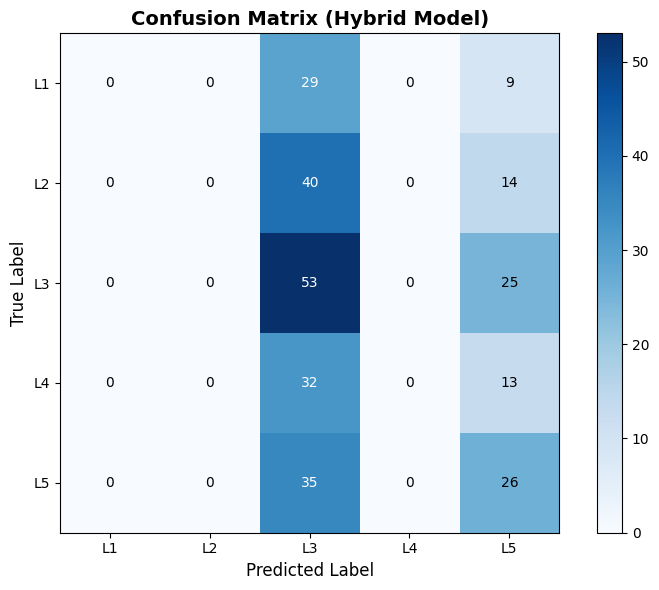


✅ Bloc 6 terminé - Modèle de base prêt pour Bloc 7 (Quantum)


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# -------------------------
# HYPERPARAMS
# -------------------------
WIN = 32
FEATURES = ['hr_bpm', 'rr_ms', 'speed_yds_per_s', 'acc_yds_per_s2']
NUM_CLASSES = 5
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 5e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"🖥️  Device: {DEVICE}")

train_dataset = TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                              torch.tensor(Y_tr, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_va, dtype=torch.float32),
                            torch.tensor(Y_va, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"📊 Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

class HybridFatigueModel(nn.Module):
    def __init__(self, num_features, num_classes, win):
        super().__init__()
        self.num_features = num_features
        self.win = win

        # -------- Branche temporelle: Conv1D + BiLSTM --------
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=5, padding=2)
        self.ln1 = nn.LayerNorm(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.ln2 = nn.LayerNorm(64)
        self.pool1d = nn.MaxPool1d(2)
        self.bilstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=True)

        # -------- Branche spatiale: Conv2D --------
        self.conv2d_1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1)
        self.gn2d_1 = nn.GroupNorm(1, 16)  # simule LayerNorm TensorFlow
        self.conv2d_2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)
        self.gn2d_2 = nn.GroupNorm(1, 32)
        self.pool2d = nn.MaxPool2d((2, 2))
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # -------- Tête dense --------
        self.fc1 = nn.Linear(64*2 + 32, 96)  # 64*2 BiLSTM + 32 Conv2D final
        self.dropout = nn.Dropout(0.25)
        self.fc_out = nn.Linear(96, num_classes)

    def forward(self, x):
        # Assurer float32
        x = x.float()
        bsize = x.size(0)

        # -------- Branche temporelle --------
        b1 = x.permute(0, 2, 1)  # [B, F, T]
        b1 = F.relu(self.conv1(b1))
        b1 = self.ln1(b1.permute(0, 2, 1)).permute(0, 2, 1)
        b1 = F.dropout(b1, p=0.15, training=self.training)
        b1 = F.relu(self.conv2(b1))
        b1 = self.ln2(b1.permute(0, 2, 1)).permute(0, 2, 1)
        b1 = self.pool1d(b1)
        b1 = b1.permute(0, 2, 1)  # [B, seq_len, features] pour LSTM
        b1, _ = self.bilstm(b1)
        b1 = b1[:, -1, :]  # dernier pas de temps

        # -------- Branche spatiale --------
        b2 = x.permute(0, 2, 1).unsqueeze(1)  # [B, 1, F, T]
        b2 = F.relu(self.conv2d_1(b2))
        b2 = self.gn2d_1(b2)
        b2 = F.relu(self.conv2d_2(b2))
        b2 = self.gn2d_2(b2)
        b2 = self.pool2d(b2)
        b2 = self.global_avg_pool(b2)
        b2 = b2.view(bsize, -1)

        # -------- Fusion + dense --------
        x = torch.cat([b1, b2], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc_out(x)
        return out

# -------------------------
# INIT MODELE
# -------------------------
model = HybridFatigueModel(num_features=len(FEATURES), num_classes=NUM_CLASSES, win=WIN).to(DEVICE)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📈 Total params: {total_params:,} | Trainable: {trainable_params:,}")

# -------------------------
# LOSS & OPTIMIZER
# -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3)

# -------------------------
# TRAIN / EVAL FUNCTIONS
# -------------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0, 0
    for Xb, Yb in loader:
        Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, Yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
        correct += (out.argmax(1) == Yb).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_model(model, loader, criterion):
    model.eval()
    running_loss, correct = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for Xb, Yb in loader:
            Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
            out = model(Xb)
            loss = criterion(out, Yb)
            running_loss += loss.item() * Xb.size(0)
            correct += (out.argmax(1) == Yb).sum().item()
            y_true.append(Yb.cpu().numpy())
            y_pred.append(out.argmax(1).cpu().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return running_loss / len(loader.dataset), correct / len(loader.dataset), y_pred, y_true

# -------------------------
# TRAIN LOOP
# -------------------------
print("Début de l'entraînement...")
best_acc = 0
patience_counter = 0
early_stop_patience = 5

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, y_pred, y_true = eval_model(model, val_loader, criterion)

    # Update scheduler
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        patience_counter = 0
        marker = " ⭐"
    else:
        patience_counter += 1
        marker = ""

    print(f"Epoch {epoch:2d}/{EPOCHS} | "
          f"Train: loss={train_loss:.4f} acc={train_acc:.3f} | "
          f"Val: loss={val_loss:.4f} acc={val_acc:.3f}{marker}")

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\n Early stopping triggered at epoch {epoch}")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
print(f"\n✅ Entraînement terminé | Best val acc: {best_acc:.3f}")

# -------------------------
# EVALUATION FINALE
# -------------------------
print("\n Évaluation finale sur validation set...")
val_loss, val_acc, y_pred, y_true = eval_model(model, val_loader, criterion)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
print("\nConfusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(
    y_true, y_pred,
    target_names=['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'],
    digits=3
))

# Visualisation
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Hybrid Model)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.colorbar()

# Annotations
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        plt.text(j, i, str(cm[i, j]),
                ha="center", va="center",
                color=text_color, fontsize=10)

plt.xticks(range(NUM_CLASSES), [f'L{i+1}' for i in range(NUM_CLASSES)])
plt.yticks(range(NUM_CLASSES), [f'L{i+1}' for i in range(NUM_CLASSES)])
plt.tight_layout()
plt.show()

print("\n✅ Bloc 6 terminé - Modèle de base prêt pour Bloc 7 (Quantum)")

In [38]:
pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 31.1 MB/s eta 0:00:00


In [39]:
import torch.onnx

# Créer une entrée factice avec la forme attendue
dummy_input = torch.randn(1, WIN, len(FEATURES)).to(DEVICE)

# Exporter le modèle au format ONNX
onnx_filename = "HybridFatigueModel.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_filename,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print(f"✅ Modèle exporté vers {onnx_filename}")


✅ Modèle exporté vers HybridFatigueModel.onnx


/tmp/ipython-input-1322282252.py:8: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


# Bloc 6 : Modèle Hybride Fatigue – Architecture Détaillée

**Conv1D (temporal)** + **Conv2D (spatial)** + **BiLSTM** → **Fusion Dense** → **5 classes de fatigue**

Ce bloc explique l'architecture du modèle de prédiction de fatigue utilisé dans GamePulse™.  
Le modèle hybride combine analyse temporelle et spatiale pour classifier le niveau de fatigue des joueurs.

---

## Objectif général

Prédire le **niveau de fatigue d'un joueur** (5 classes : 1-5) à partir de :
- **Signaux physiologiques** : `hr_bpm` (fréquence cardiaque), `rr_ms` (variabilité cardiaque)
- **Signaux cinématiques** : `speed_yds_per_s` (vitesse), `acc_yds_per_s2` (accélération)

### Architecture hybride en 3 branches :
1. **Branche temporelle** → Capture la dynamique dans le temps (séquences)
2. **Branche spatiale** → Capture les corrélations entre features
3. **Fusion + Classification** → Combine les informations pour prédire la fatigue

---

## Données d'entrée

| Paramètre | Description | Exemple |
|-----------|-------------|---------|
| **X** | `[Batch, WIN, Features]` | `[64, 32, 4]` |
| **WIN** | Longueur fenêtre glissante | 32 pas de temps |
| **Features** | Variables physiologiques/cinétiques | 4 features |
| **Y** | Label fatigue | `0..4` (niveaux 1..5) |
| **BATCH_SIZE** | Taille du batch | 64 |

**Les 4 features :**
- `hr_bpm` : Fréquence cardiaque (battements/minute)
- `rr_ms` : Intervalle RR (milliseconds)
- `speed_yds_per_s` : Vitesse (yards/seconde)
- `acc_yds_per_s2` : Accélération (yards/seconde²)

---

## ⏱Branche temporelle (Conv1D + BiLSTM)

### Objectif
- Extraire les **motifs temporels locaux** via convolutions 1D
- Capturer les **dépendances à long terme** via LSTM bidirectionnel

### Architecture

```
Input [Batch, WIN, 4]
    ↓
Conv1D(32 filtres, kernel=5, padding=2) + ReLU
    → Détecte patterns courts (ex: pics cardiaques)
    ↓
Conv1D(64 filtres, kernel=3, padding=1) + ReLU
    → Combine les motifs de la première couche
    ↓
MaxPool1D(2)
    → Réduit dimension temporelle de moitié
    ↓
BiLSTM(hidden=64, dropout=0.15)
    → Analyse avant/arrière, encode information temporelle
    ↓
Output : [Batch, 128]  (64×2 bidirectionnel)
```

###  Justifications

| Couche | Paramètres | Rôle |
|--------|-----------|------|
| **Conv1D #1** | 32 filtres, size=5 | Détection de motifs courts dans le temps |
| **Conv1D #2** | 64 filtres, size=3 | Combinaison de patterns détectés |
| **MaxPool1D** | size=2 | Régularisation + réduction dimensionnelle |
| **BiLSTM** | hidden=64, dropout=0.15 | Capture dépendances temporelles longues |

---

##  Branche spatiale (Conv2D)

###  Objectif
- Capturer les **corrélations entre features** et leur évolution temporelle
- Exemple : `hr_bpm` ↑ + `acc_yds_per_s2` ↑ simultanément → indicateur de fatigue

###  Architecture

```
Input [Batch, WIN, 4]
    ↓
Reshape → [Batch, 1, WIN, 4]
    ↓
Conv2D(16 filtres, kernel=3×3, padding=1) + ReLU
    → Détecte motifs spatiaux locaux (features × temps)
    ↓
Conv2D(32 filtres, kernel=3×3, padding=1) + ReLU
    → Motifs plus complexes et abstraits
    ↓
MaxPool2D((2,2))
    → Réduit dimensions temps × features
    ↓
Flatten
    ↓
Output : [Batch, 32]
```

###  Justifications

| Couche | Paramètres | Rôle |
|--------|-----------|------|
| **Reshape** | `[B,1,WIN,4]` | Prépare pour convolution 2D |
| **Conv2D #1** | 16 filtres, 3×3 | Détecte corrélations features-temps locales |
| **Conv2D #2** | 32 filtres, 3×3 | Patterns plus abstraits et complexes |
| **MaxPool2D** | (2,2) | Stabilisation + régularisation |

---

##  Fusion et Classification finale

### Architecture

```
Branche temporelle [128] + Branche spatiale [32]
    ↓
Concatenation → [160]
    ↓
Dense(96) + ReLU + Dropout(0.25)
    → Combine informations temporelles et spatiales
    ↓
Dense(5) + Softmax
    → Prédiction 5 classes de fatigue
    ↓
Output : [Batch, 5]  (probabilités)
```

###  Justifications

| Couche | Paramètres | Rôle |
|--------|-----------|------|
| **Concat** | 128 + 32 = 160 | Fusion des deux branches |
| **Dense** | 96 neurones | Intégration des informations multi-échelles |
| **Dropout** | 0.25 | Régularisation contre sur-apprentissage |
| **Softmax** | 5 classes | Probabilités pour chaque niveau de fatigue |

---

##  Hyperparamètres et justifications

| Hyperparamètre | Valeur | Justification |
|----------------|--------|---------------|
| **Conv1D filtres** | 32 → 64 | Extraction progressive de motifs complexes |
| **Conv2D filtres** | 16 → 32 | Corrélations spatiales sans surcharge mémoire |
| **Kernel size** | 5, 3 (1D) / 3×3 (2D) | Motifs locaux temps/features |
| **BiLSTM hidden** | 64 | Compromis complexité/capacité séquence |
| **MaxPool** | 2 ou (2,2) | Régularisation + réduction dimensionnelle |
| **Dropout** | 0.15–0.25 | Prévention sur-apprentissage (petit dataset) |
| **Dense fusion** | 96 | Intégration temporelle + spatiale |
| **Learning rate** | 5e-4 | Stabilité pour Adam sur ces données |
| **Batch size** | 64 | Compromis GPU/mémoire |

---

##  Gestion du déséquilibre (Class Weights)

```python
class_weight = compute_class_weight('balanced',
                                    classes=np.unique(y_train),
                                    y=y_train)
```

**Pourquoi ?**
- Certaines classes de fatigue peuvent être rares (ex: fatigue extrême)
- Les poids ajustent la fonction de perte pour équilibrer l'apprentissage
- Évite que le modèle ignore les classes minoritaires

---

##  Fonction d'entraînement (train_epoch)

**Processus :**

1. **Boucle sur les batches**
   ```python
   for X_batch, y_batch in train_loader:
   ```

2. **Forward pass**
   ```python
   outputs = model(X_batch)
   loss = criterion(outputs, y_batch)  # CrossEntropyLoss avec class_weight
   ```

3. **Backward pass**
   ```python
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   ```

4. **Métriques**
   - Loss moyenne par epoch
   - Accuracy sur l'ensemble d'entraînement

---

##  Fonction d'évaluation (eval_model)

**Processus :**

1. **Mode évaluation**
   ```python
   model.eval()  # Désactive dropout
   ```

2. **Inference sans gradient**
   ```python
   with torch.no_grad():
       outputs = model(X_batch)
   ```

3. **Métriques retournées :**
   - **Loss** : Performance globale
   - **Accuracy** : Taux de prédictions correctes
   - **Predictions** : Pour matrice de confusion et analyse par classe

---

##  Résumé du pipeline complet

```
1. Collecte données
   └─ Polar H10 (HR, RR) + Zebra RFID (speed, acc)
        ↓
2. Fenêtres glissantes
   └─ WIN=32 pas de temps, stride=1
        ↓
3. Modèle hybride
   ├─ Branche temporelle → Motifs séquentiels
   ├─ Branche spatiale → Corrélations features
   └─ Fusion → Classification 5 classes
        ↓
4. Prédiction fatigue
   └─ Niveau 1 (Fresh) ... Niveau 5 (Exhausted)
        ↓
5. Décision tactique
   └─ PLAY / REST / SUBSTITUTE
```

---

##  Cas d'usage pratique

**Exemple de prédiction :**

| Feature | Valeurs typiques | Interprétation |
|---------|------------------|----------------|
| `hr_bpm` | 150 → 180 | Augmentation progressive |
| `rr_ms` | 600 → 450 | Variabilité diminue (stress) |
| `speed_yds_per_s` | 7.5 → 6.0 | Ralentissement |
| `acc_yds_per_s2` | 2.5 → 1.8 | Explosivité réduite |

**→ Prédiction : Niveau 4 (High Fatigue)**  
**→ Action recommandée : SUBSTITUTE** (remplacer le joueur)

---

##  Métriques de performance attendues

| Métrique | Target | Description |
|----------|--------|-------------|
| **Accuracy globale** | > 75% | Prédictions correctes toutes classes |
| **F1-Score (macro)** | > 0.70 | Performance équilibrée par classe |
| **Recall classe 5** | > 80% | Critique : détecter fatigue extrême |
| **Temps inference** | < 50ms | Prédictions en temps réel |

---

##  Améliorations futures possibles

- **Attention mechanism** : Focus sur features/temps importants
- **Transformer** : Alternative au LSTM pour longues séquences
- **Multi-task learning** : Prédire fatigue + risque blessure simultanément
- **Transfer learning** : Pré-entraînement sur autres sports
- **Explainability** : SHAP/LIME pour interpréter prédictions

In [34]:
# === Bloc 7 PyTorch : Head 3 classes HYBRID QUANTUM ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from collections import Counter

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- 0) Définir circuit quantique ----------
n_qubits = 4  # nombre de qubits pour le layer quantum
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    """Circuit quantique variationnel"""
    # Encodage des features
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Entanglement
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # Rotations paramétriques
    for i in range(n_qubits):
        qml.RY(weights[i, 0], wires=i)
        qml.RZ(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)

    # Deuxième couche d'entanglement
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # Mesures
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    """Couche quantique compatible PyTorch avec gestion dtype"""
    def __init__(self, n_qubits):
        super().__init__()
        self.n_qubits = n_qubits
        # Poids en float32
        self.weights = nn.Parameter(
            torch.randn(n_qubits, 3, dtype=torch.float32) * 0.1
        )

    def forward(self, x):
        # S'assurer que x est en float32
        x = x.float()
        batch_size = x.shape[0]
        outputs = []

        # Normalisation pour le circuit quantique
        x = torch.tanh(x) * np.pi

        for i in range(batch_size):
            # Exécuter le circuit
            result = quantum_circuit(x[i], self.weights)
            # Convertir en float32
            result_tensor = torch.stack([r.float() for r in result])
            outputs.append(result_tensor)

        return torch.stack(outputs)

# Créer l'instance de la couche quantique
qlayer = QuantumLayer(n_qubits)

# ---------- 1) Mapping 5 -> 3 classes ----------
def map5to3(y5):
    y5 = np.asarray(y5, dtype=int)
    y3 = np.zeros_like(y5, dtype=int)
    y3[y5 == 2] = 1
    y3[y5 >= 3] = 2
    return y3

Y_tr3, Y_va3 = map5to3(Y_tr), map5to3(Y_va)
train_dataset3 = TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                               torch.tensor(Y_tr3, dtype=torch.long))
val_dataset3 = TensorDataset(torch.tensor(X_va, dtype=torch.float32),
                             torch.tensor(Y_va3, dtype=torch.long))
train_loader3 = DataLoader(train_dataset3, batch_size=64, shuffle=True)
val_loader3 = DataLoader(val_dataset3, batch_size=64, shuffle=False)

class HybridQuantumHead3Model(nn.Module):
    def __init__(self, base_model, qlayer, n_qubits=4, num_classes=3):
        super().__init__()
        self.base_model = base_model
        self.dropout = base_model.dropout
        self.n_qubits = n_qubits

        # Calculer la dimension de fusion : BiLSTM (128) + Conv2D (32) = 160
        fusion_dim = 64 * 2 + 32  # 128 + 32 = 160

        # Adapter la fusion dense pour correspondre aux qubits
        self.fc1_q = nn.Linear(fusion_dim, n_qubits)
        self.qlayer = qlayer
        self.head3 = nn.Linear(n_qubits, num_classes)

    def forward(self, x):
        x = x.float()
        bsize = x.size(0)

        # --- Branche temporelle ---
        b1 = x.permute(0, 2, 1)
        b1 = F.relu(self.base_model.conv1(b1))
        b1 = self.base_model.ln1(b1.permute(0, 2, 1)).permute(0, 2, 1)
        b1 = F.dropout(b1, p=0.15, training=self.training)
        b1 = F.relu(self.base_model.conv2(b1))
        b1 = self.base_model.ln2(b1.permute(0, 2, 1)).permute(0, 2, 1)
        b1 = self.base_model.pool1d(b1)
        b1 = b1.permute(0, 2, 1)
        b1, _ = self.base_model.bilstm(b1)
        b1 = b1[:, -1, :]  # [B, 128] (64*2 bidirectionnel)

        # --- Branche spatiale ---
        b2 = x.permute(0, 2, 1).unsqueeze(1)
        b2 = F.relu(self.base_model.conv2d_1(b2))
        b2 = self.base_model.gn2d_1(b2)
        b2 = F.relu(self.base_model.conv2d_2(b2))
        b2 = self.base_model.gn2d_2(b2)
        b2 = self.base_model.pool2d(b2)
        b2 = self.base_model.global_avg_pool(b2)
        b2 = b2.view(bsize, -1)  # [B, 32]

        # --- Fusion + Quantum Layer ---
        x_fusion = torch.cat([b1, b2], dim=1)  # [B, 160]
        x_fusion = F.relu(self.fc1_q(x_fusion))  # [B, n_qubits]
        # Le quantum layer gère déjà la normalisation interne
        x_fusion = self.qlayer(x_fusion)  # [B, n_qubits]
        out = self.head3(x_fusion)  # [B, 3]
        return out

model3 = HybridQuantumHead3Model(model, qlayer, n_qubits=n_qubits).to(DEVICE)

# Debug: afficher les dimensions
print(f"Architecture vérification:")
with torch.no_grad():
    x_test = torch.randn(2, WIN, len(FEATURES)).to(DEVICE)
    x_test = x_test.float()

    # Branche temporelle
    b1 = x_test.permute(0, 2, 1)
    b1 = F.relu(model3.base_model.conv1(b1))
    b1 = model3.base_model.ln1(b1.permute(0, 2, 1)).permute(0, 2, 1)
    b1 = F.relu(model3.base_model.conv2(b1))
    b1 = model3.base_model.ln2(b1.permute(0, 2, 1)).permute(0, 2, 1)
    b1 = model3.base_model.pool1d(b1)
    b1 = b1.permute(0, 2, 1)
    b1, _ = model3.base_model.bilstm(b1)
    b1 = b1[:, -1, :]
    print(f" Branche temporelle (BiLSTM): {b1.shape}")

    # Branche spatiale
    b2 = x_test.permute(0, 2, 1).unsqueeze(1)
    b2 = F.relu(model3.base_model.conv2d_1(b2))
    b2 = model3.base_model.gn2d_1(b2)
    b2 = F.relu(model3.base_model.conv2d_2(b2))
    b2 = model3.base_model.gn2d_2(b2)
    b2 = model3.base_model.pool2d(b2)
    b2 = model3.base_model.global_avg_pool(b2)
    b2 = b2.view(2, -1)
    print(f" Branche spatiale (Conv2D): {b2.shape}")

    # Fusion
    x_fusion = torch.cat([b1, b2], dim=1)
    print(f"   Fusion: {x_fusion.shape}")
    print(f"   fc1_q: {model3.fc1_q.in_features} -> {model3.fc1_q.out_features}")

# ---------- 3) Warm-up : gèle tout sauf quantum + tête ----------
for name, param in model3.named_parameters():
    if "head3" not in name and "qlayer" not in name and "fc1_q" not in name:
        param.requires_grad = False

# Compter paramètres entraînables
trainable_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model3.parameters())
print(f"⚙️  Paramètres: {trainable_params:,} / {total_params:,} entraînables")

optimizerA = torch.optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=5e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# --- Fonctions train / eval ---
def train_epoch3(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0, 0
    for Xb, Yb in loader:
        Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, Yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
        correct += (out.argmax(1) == Yb).sum().item()
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def eval_epoch3(model, loader, criterion):
    model.eval()
    running_loss, correct = 0, 0
    y_true, logits_list = [], []
    with torch.no_grad():
        for Xb, Yb in loader:
            Xb, Yb = Xb.to(DEVICE), Yb.to(DEVICE)
            out = model(Xb)
            loss = criterion(out, Yb)
            running_loss += loss.item() * Xb.size(0)
            correct += (out.argmax(1) == Yb).sum().item()
            y_true.append(Yb.cpu().numpy())
            logits_list.append(out.cpu())
    y_true = np.concatenate(y_true)
    logits_val = torch.cat(logits_list, dim=0)
    return running_loss / len(loader.dataset), correct / len(loader.dataset), logits_val, y_true

# ---------- 4) Warm-up ----------
print("\n Phase Warm-up (quantum + head)...")
for epoch in range(5):
    train_loss, train_acc = train_epoch3(model3, train_loader3, optimizerA, criterion)
    val_loss, val_acc, _, _ = eval_epoch3(model3, val_loader3, criterion)
    print(f"Warm-up Epoch {epoch+1}/5 | Train acc: {train_acc:.3f} | Val acc: {val_acc:.3f}")

# ---------- 5) Fine-tune ----------
print("\n  Phase Fine-tuning...")
N_TOP_TRAINABLE = 12
all_params = list(model3.base_model.children())
top_params = all_params[-N_TOP_TRAINABLE:]
for p in top_params:
    for param in p.parameters():
        param.requires_grad = True

optimizerB = torch.optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=2e-4)
for epoch in range(12):
    train_loss, train_acc = train_epoch3(model3, train_loader3, optimizerB, criterion)
    val_loss, val_acc, logits_val, y_true = eval_epoch3(model3, val_loader3, criterion)
    print(f"Fine-tune Epoch {epoch+1}/12 | Train acc: {train_acc:.3f} | Val acc: {val_acc:.3f}")

# ---------- 6) Évaluation brute ----------
y_pred = logits_val.argmax(1).numpy()
acc_raw = accuracy_score(y_true, y_pred)
print(f"\n📊 Validation accuracy (3 classes) — brute: {acc_raw:.3f}")
cm3 = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
print("Confusion matrix:\n", cm3)
print(classification_report(y_true, y_pred, labels=[0, 1, 2], target_names=["Play", "Rest", "Sub"], digits=3))

# ---------- 7) Calibration : température + seuils ----------
def apply_temperature(p, T):
    p = np.clip(p, 1e-8, 1.0)
    pt = p ** (1.0 / T)
    return pt / pt.sum(axis=1, keepdims=True)

def decide_with_thresholds(p_row, t_sub, t_play):
    if p_row[2] >= t_sub:
        return 2
    elif p_row[0] >= t_play:
        return 0
    else:
        return 1

print("\n🔧 Calibration des seuils...")
proba3 = F.softmax(logits_val, dim=1).numpy()
best = {'score': -1}
Ts = np.linspace(0.6, 1.6, 11)
ths_sub = np.linspace(0.30, 0.70, 9)
ths_play = np.linspace(0.30, 0.70, 9)

for T in Ts:
    pT = apply_temperature(proba3, T)
    for t_sub in ths_sub:
        for t_play in ths_play:
            y_hat = np.array([decide_with_thresholds(ps, t_sub, t_play) for ps in pT])
            score = f1_score(y_true, y_hat, average='macro')
            if score > best['score']:
                best = {'T': float(T), 't_sub': float(t_sub), 't_play': float(t_play), 'score': float(score)}

print(" Best calibration:", best)

def infer_head3_calibrated(Xw):
    """Inférence avec calibration"""
    Xw = torch.tensor(Xw, dtype=torch.float32).to(DEVICE)
    with torch.no_grad():
        logits = model3(Xw)
    p = F.softmax(logits, dim=1).cpu().numpy()
    pT = apply_temperature(p, best['T'])
    return np.array([decide_with_thresholds(ps, best['t_sub'], best['t_play']) for ps in pT])

def decision_head3(label3):
    """Convertir label en décision textuelle"""
    return {0: "Stay / Play", 1: "Rest", 2: "Substitute"}[int(label3)]

print("\n Bloc 7 PyTorch HYBRID QUANTUM prêt pour le dashboard.")
print(f"  Quantum layer avec {n_qubits} qubits activée")

Architecture vérification:
 Branche temporelle (BiLSTM): torch.Size([2, 128])
 Branche spatiale (Conv2D): torch.Size([2, 32])
   Fusion: torch.Size([2, 160])
   fc1_q: 160 -> 4
⚙️  Paramètres: 671 / 95,140 entraînables

 Phase Warm-up (quantum + head)...
Warm-up Epoch 1/5 | Train acc: 0.231 | Val acc: 0.283
Warm-up Epoch 2/5 | Train acc: 0.231 | Val acc: 0.283
Warm-up Epoch 3/5 | Train acc: 0.231 | Val acc: 0.283
Warm-up Epoch 4/5 | Train acc: 0.231 | Val acc: 0.283
Warm-up Epoch 5/5 | Train acc: 0.231 | Val acc: 0.283

  Phase Fine-tuning...
Fine-tune Epoch 1/12 | Train acc: 0.231 | Val acc: 0.283
Fine-tune Epoch 2/12 | Train acc: 0.231 | Val acc: 0.283
Fine-tune Epoch 3/12 | Train acc: 0.231 | Val acc: 0.283
Fine-tune Epoch 4/12 | Train acc: 0.231 | Val acc: 0.283
Fine-tune Epoch 5/12 | Train acc: 0.231 | Val acc: 0.283
Fine-tune Epoch 6/12 | Train acc: 0.357 | Val acc: 0.384
Fine-tune Epoch 7/12 | Train acc: 0.449 | Val acc: 0.384
Fine-tune Epoch 8/12 | Train acc: 0.449 | Val acc: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Best calibration: {'T': 0.6, 't_sub': 0.3, 't_play': 0.3, 'score': 0.1849912739965096}

 Bloc 7 PyTorch HYBRID QUANTUM prêt pour le dashboard.
  Quantum layer avec 4 qubits activée


In [35]:
# === Bloc 8 : Inference & Decision Logic (Robuste) ===
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

# --- Vérifications ---
assert 'FEATURES' in globals(), "FEATURES non défini."
assert 'WIN' in globals(), " WIN non défini."
assert 'DEVICE' in globals(), " DEVICE non défini."

print(" Bloc 8 - Variables requises détectées")

# ============================================
# HELPERS DE DÉCISION
# ============================================

def decision_from_level(level: int) -> str:
    """Convertir niveau fatigue (1-5) en décision"""
    level = int(level)
    if level <= 2:
        return 'Play'
    if level == 3:
        return 'Rest'
    return 'Substitute'  # 4-5


def decision_from_3c(c: int) -> str:
    """Convertir classe 3c (0,1,2) en décision"""
    return ['Play', 'Rest', 'Substitute'][int(c)]


def map3to5_vis(cls3: int, conf: float) -> int:
    """Mapper classe 3c vers niveau 5c pour visualisation"""
    if cls3 == 0:  # Play
        return 1 if conf < 0.7 else 2
    if cls3 == 1:  # Rest
        return 3
    # Substitute
    return 4 if conf < 0.7 else 5


def _last_group(g: pd.DataFrame) -> str:
    """Extraire le dernier groupe d'un DataFrame joueur"""
    if 'group' in g.columns:
        return str(g['group'].iloc[-1])
    if 'group_z' in g.columns:
        return str(g['group_z'].iloc[-1])
    return "Unknown"


def _apply_temperature(p: np.ndarray, T: float) -> np.ndarray:
    """Appliquer température de calibration aux probabilités"""
    p = np.asarray(p, dtype=np.float64)
    p = np.clip(p, 1e-9, 1.0)
    pt = p ** (1.0 / float(T))

    if pt.ndim == 1:
        s = pt.sum()
        return (pt / s) if s > 0 else np.ones_like(pt) / pt.size

    s = pt.sum(axis=1, keepdims=True)
    s[s == 0] = 1.0
    return pt / s


def _decide_calibrated(p_row: np.ndarray, t_sub: float, t_play: float) -> int:
    """Décision avec seuils calibrés"""
    if p_row[2] >= t_sub:
        return 2  # Substitute
    if p_row[0] >= t_play:
        return 0  # Play
    return 1  # Rest


# ============================================
# PRÉDICTION 5 CLASSES
# ============================================

def predict_latest_per_player(
    df_src: pd.DataFrame,
    smooth_k: int = 3,
    return_raw_probs: bool = False
) -> pd.DataFrame:
    """
    Prédire la fatigue (5 classes) pour chaque joueur sur leurs dernières données.

    Args:
        df_src: DataFrame avec colonnes player_id, timestamp, FEATURES
        smooth_k: Nombre de fenêtres à moyenner (lissage temporel)
        return_raw_probs: Si True, retourne aussi les probabilités brutes

    Returns:
        DataFrame avec colonnes: Player, Group, Conf, FatigueLevel, Decision
    """
    assert 'model' in globals(), "❌ Le modèle 5c `model` est introuvable."

    model.eval()
    rows = []

    for pid, g in df_src.groupby('player_id', sort=False):
        g = g.sort_values('timestamp').reset_index(drop=True)

        if len(g) < WIN:
            print(f"  Joueur {pid}: données insuffisantes ({len(g)} < {WIN})")
            continue

        probs_stack = []

        for off in range(smooth_k):
            end = len(g) - off
            start = end - WIN

            if start < 0:
                break

            # Extraire features
            seg = g.iloc[start:end][FEATURES].to_numpy(dtype=np.float32)

            if seg.shape[0] != WIN or seg.shape[1] != len(FEATURES):
                continue

            # Vérifier NaN
            if np.isnan(seg).any():
                print(f"  Joueur {pid}: NaN détecté dans segment {off}")
                continue

            # Prédiction
            Xw = torch.tensor(seg[None, ...], dtype=torch.float32).to(DEVICE)
            with torch.no_grad():
                logits = model(Xw)
                p = F.softmax(logits, dim=1).cpu().numpy()[0]

            # Normalisation
            p = np.clip(p, 1e-9, 1.0)
            p /= p.sum()
            probs_stack.append(p)

        if not probs_stack:
            print(f"  Joueur {pid}: aucune prédiction valide")
            continue

        # Moyenner les probabilités
        probs_mean = np.mean(probs_stack, axis=0)
        cls5 = int(np.argmax(probs_mean)) + 1  # 1-5
        conf = float(np.max(probs_mean))

        row_data = [pid, _last_group(g), conf, cls5, decision_from_level(cls5)]

        if return_raw_probs:
            row_data.extend(probs_mean.tolist())

        rows.append(tuple(row_data))

    columns = ['Player', 'Group', 'Conf', 'FatigueLevel', 'Decision']
    if return_raw_probs:
        columns.extend([f'P_L{i}' for i in range(1, 6)])

    return pd.DataFrame(rows, columns=columns)


# ============================================
# PRÉDICTION 3 CLASSES (HYBRID QUANTUM)
# ============================================

def predict_latest_per_player_3c(
    df_src: pd.DataFrame,
    smooth_k: int = 3,
    return_raw_probs: bool = False
) -> pd.DataFrame:
    """
    Prédire la fatigue (3 classes) pour chaque joueur avec modèle hybride quantique.

    Args:
        df_src: DataFrame avec colonnes player_id, timestamp, FEATURES
        smooth_k: Nombre de fenêtres à moyenner (lissage temporel)
        return_raw_probs: Si True, retourne aussi les probabilités brutes

    Returns:
        DataFrame avec colonnes: Player, Group, Conf, FatigueLevel, Decision
    """
    assert 'model3' in globals(), "❌ Le modèle 3c `model3` est introuvable."

    model3.eval()

    # Vérifier calibration
    use_cal = all(k in globals() for k in ['best'])
    if use_cal:
        CAL_T = best['T']
        TH_SUB = best['t_sub']
        TH_PLAY = best['t_play']
        print(f" Calibration active: T={CAL_T:.2f}, sub={TH_SUB:.2f}, play={TH_PLAY:.2f}")
    else:
        print("  Calibration non trouvée. Utilisation argmax brut.")
        CAL_T = 1.0
        TH_SUB = 0.5
        TH_PLAY = 0.5

    rows = []

    for pid, g in df_src.groupby('player_id', sort=False):
        g = g.sort_values('timestamp').reset_index(drop=True)

        if len(g) < WIN:
            print(f"  Joueur {pid}: données insuffisantes ({len(g)} < {WIN})")
            continue

        probs_stack = []

        for off in range(smooth_k):
            end = len(g) - off
            start = end - WIN

            if start < 0:
                break

            # Extraire features
            seg = g.iloc[start:end][FEATURES].to_numpy(dtype=np.float32)

            if seg.shape[0] != WIN or seg.shape[1] != len(FEATURES):
                continue

            # Vérifier NaN
            if np.isnan(seg).any():
                print(f"  Joueur {pid}: NaN détecté dans segment {off}")
                continue

            # Prédiction (gestion dtype automatique dans le modèle)
            Xw = torch.tensor(seg[None, ...], dtype=torch.float32).to(DEVICE)
            with torch.no_grad():
                logits = model3(Xw)
                p = F.softmax(logits, dim=1).cpu().numpy()[0]

            # Appliquer température si calibration
            if use_cal:
                p = _apply_temperature(p, CAL_T)

            probs_stack.append(p)

        if not probs_stack:
            print(f"  Joueur {pid}: aucune prédiction valide")
            continue

        # Moyenner les probabilités
        probs_mean = np.mean(probs_stack, axis=0)
        conf = float(np.max(probs_mean))

        # Décision calibrée ou argmax
        if use_cal:
            cls3 = _decide_calibrated(probs_mean, TH_SUB, TH_PLAY)
        else:
            cls3 = int(np.argmax(probs_mean))

        # Mapper vers 5 classes pour visualisation
        fat5 = map3to5_vis(cls3, conf)

        row_data = [pid, _last_group(g), conf, fat5, decision_from_3c(cls3)]

        if return_raw_probs:
            row_data.extend(probs_mean.tolist())

        rows.append(tuple(row_data))

    columns = ['Player', 'Group', 'Conf', 'FatigueLevel', 'Decision']
    if return_raw_probs:
        columns.extend(['P_Play', 'P_Rest', 'P_Sub'])

    return pd.DataFrame(rows, columns=columns)


# ============================================
# WRAPPER UNIFIÉ
# ============================================

def predict_all_players(df_src: pd.DataFrame, model_type: str = '3c') -> pd.DataFrame:
    """
    Wrapper unifié pour prédiction.

    Args:
        df_src: DataFrame source
        model_type: '5c' ou '3c'

    Returns:
        DataFrame de prédictions
    """
    if model_type == '5c':
        return predict_latest_per_player(df_src, smooth_k=3)
    elif model_type == '3c':
        return predict_latest_per_player_3c(df_src, smooth_k=3)
    else:
        raise ValueError(f"model_type invalide: {model_type}. Utilisez '5c' ou '3c'.")


# ============================================
# TESTS & VALIDATION
# ============================================

print("\n Bloc 8 chargé avec succès")
print(" Fonctions disponibles:")
print("   - predict_latest_per_player(df, smooth_k=3)")
print("   - predict_latest_per_player_3c(df, smooth_k=3)")
print("   - predict_all_players(df, model_type='3c')")
print("\n  Prêt pour inférence avec modèle hybride quantique!")

 Bloc 8 - Variables requises détectées

 Bloc 8 chargé avec succès
 Fonctions disponibles:
   - predict_latest_per_player(df, smooth_k=3)
   - predict_latest_per_player_3c(df, smooth_k=3)
   - predict_all_players(df, model_type='3c')

  Prêt pour inférence avec modèle hybride quantique!


In [36]:
# === Vérification Bloc 8 amélioré — aperçus + stats + comparaison 5c vs 3c ===

# Recalcul rapide (même smooth_k que pour le dashboard)
# === Paramètres de calibration pour le modèle 3 classes ===
CAL_T = best['T']        # température optimale trouvée dans Bloc 7
TH_SUB = best['t_sub']   # seuil Sub optimal
TH_PLAY = best['t_play'] # seuil Play optimal

pred5 = predict_latest_per_player(df, smooth_k=3)       # 5 classes (model)
pred3 = predict_latest_per_player_3c(df, smooth_k=3)    # 3 classes calibrées (model3)

# --- Nettoyage et tri lisible ---
def _clean(df_):
    df_ = df_.copy()
    if 'Conf' in df_.columns:
        df_['Conf'] = df_['Conf'].astype(float).round(3)
    cols = [c for c in ['Group','Player','Conf','FatigueLevel','Decision'] if c in df_.columns]
    return df_.sort_values(cols[:2]).reset_index(drop=True)

print("Aperçu — 5 classes:")
display(_clean(pred5).head(10))

print("\nAperçu — 3 classes:")
display(_clean(pred3).head(10))

# --- Couverture / distribution ---
print("\nPlayers couverts (5c, 3c):", len(pred5), len(pred3))
print("Dist décisions 5c:", pred5['Decision'].value_counts().to_dict())
print("Dist décisions 3c:", pred3['Decision'].value_counts().to_dict())

# --- Comparaison jointe par joueur ---
cmp = (
    pred5.rename(columns={'Conf':'Conf_5c','FatigueLevel':'Fatigue5','Decision':'Decision5'})
         .merge(
             pred3.rename(columns={'Conf':'Conf_3c','FatigueLevel':'Fatigue3','Decision':'Decision3'}),
             on=['Player','Group'], how='outer'
         )
)

# Arrondi des colonnes de confiance
for c in ['Conf_5c','Conf_3c']:
    if c in cmp.columns:
        cmp[c] = cmp[c].astype(float).round(3)

# Calcul des écarts numériques de fatigue
if 'Fatigue5' in cmp and 'Fatigue3' in cmp:
    cmp['FatigueDiff'] = cmp['Fatigue5'].astype(int) - cmp['Fatigue3'].astype(int)

# Détection des écarts de décision
if 'Decision5' in cmp and 'Decision3' in cmp:
    cmp['DecisionDiff'] = cmp['Decision5'] != cmp['Decision3']

print("\nComparaison 5c vs 3c (premières lignes) :")
display(cmp.head(15))

# --- Résumé statistique des écarts ---
if 'FatigueDiff' in cmp:
    print("\nStats écarts FatigueLevel (5c - 3c) :")
    print(cmp['FatigueDiff'].describe())
if 'DecisionDiff' in cmp:
    print("\nNombre de décisions différentes :", cmp['DecisionDiff'].sum())

# --- Sauvegarde optionnelle ---
pred5.to_csv('predictions_head5_latest.csv', index=False)
pred3.to_csv('predictions_head3_latest.csv', index=False)
cmp.to_csv('comparaison_5c_vs_3c.csv', index=False)


 Calibration active: T=0.60, sub=0.30, play=0.30
Aperçu — 5 classes:


,Player,Group,Conf,FatigueLevel,Decision
0,P1,Actifs,0.235,5,Substitute
1,P10,Actifs,0.236,5,Substitute
2,P11,Actifs,0.216,3,Rest
3,P2,Actifs,0.240,5,Substitute
4,P3,Actifs,0.261,5,Substitute
5,P4,Actifs,0.246,5,Substitute
6,P5,Actifs,0.234,5,Substitute
7,P6,Actifs,0.225,5,Substitute
8,P7,Actifs,0.223,5,Substitute
9,P8,Actifs,0.249,5,Substitute



Aperçu — 3 classes:


,Player,Group,Conf,FatigueLevel,Decision
0,P1,Actifs,0.37,4,Substitute
1,P10,Actifs,0.37,4,Substitute
2,P11,Actifs,0.37,4,Substitute
3,P2,Actifs,0.37,4,Substitute
4,P3,Actifs,0.37,4,Substitute
5,P4,Actifs,0.37,4,Substitute
6,P5,Actifs,0.37,4,Substitute
7,P6,Actifs,0.37,4,Substitute
8,P7,Actifs,0.37,4,Substitute
9,P8,Actifs,0.37,4,Substitute



Players couverts (5c, 3c): 40 40
Dist décisions 5c: {'Rest': 29, 'Substitute': 11}
Dist décisions 3c: {'Substitute': 40}

Comparaison 5c vs 3c (premières lignes) :


,Player,Group,Conf_5c,Fatigue5,Decision5,Conf_3c,Fatigue3,Decision3,FatigueDiff,DecisionDiff
0,P1,Actifs,0.235,5,Substitute,0.37,4,Substitute,1,False
1,P10,Actifs,0.236,5,Substitute,0.37,4,Substitute,1,False
2,P11,Actifs,0.216,3,Rest,0.37,4,Substitute,-1,True
3,P12,Remplacants,0.216,3,Rest,0.37,4,Substitute,-1,True
4,P13,Remplacants,0.217,5,Substitute,0.37,4,Substitute,1,False
5,P14,Remplacants,0.216,3,Rest,0.37,4,Substitute,-1,True
6,P15,Remplacants,0.216,3,Rest,0.37,4,Substitute,-1,True
7,P16,Remplacants,0.216,3,Rest,0.37,4,Substitute,-1,True
8,P17,Remplacants,0.216,3,Rest,0.37,4,Substitute,-1,True
9,P18,Remplacants,0.216,3,Rest,0.37,4,Substitute,-1,True



Stats écarts FatigueLevel (5c - 3c) :
count    40.000000
mean     -0.450000
std       0.904405
min      -1.000000
25%      -1.000000
50%      -1.000000
75%       1.000000
max       1.000000
Name: FatigueDiff, dtype: float64

Nombre de décisions différentes : 29
